In [16]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import brown
from nltk.corpus import gutenberg
from sklearn.model_selection import train_test_split
import itertools
import string
import math

In [34]:
START = '<s>'
STOP = '</s>'
UNK = '<unk>'
lamb1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
lamb2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
punc = list(string.punctuation)


In [18]:
def preprocess_Train_data(data):
    for line in data :
        line.insert(0,START)
        line.insert(0,START)
        line.append(STOP)
    words = list(itertools.chain.from_iterable(data))
    data_words = [x.lower() for x in words]
    data_words.append(UNK)
    freq = nltk.FreqDist(data_words)
    unknown = list()
    for word in freq.keys():
        if freq[word] == 1:
            unknown.append(word)
    unknown = set(unknown)
    vocab = list()
    for w in data_words :
        if w in unknown :
            vocab.append(UNK)
        else :
            vocab.append(w)
    data_words = vocab
    return data , words, data_words ,unknown

In [19]:
def create_bigram_table( data_words ):
    cfreq_2gram = nltk.ConditionalFreqDist(nltk.bigrams(data_words))
    cprob_2gram = nltk.ConditionalProbDist(cfreq_2gram, nltk.MLEProbDist)
    return cfreq_2gram,cprob_2gram

In [20]:
def create_trigram_table( data_words ):
    trigrams = nltk.trigrams(data_words)
    sen = list()
    sen = [((a,b),c) for (a,b,c) in trigrams]
    cfreq_3gram = nltk.ConditionalFreqDist(sen)
    cprob_3gram = nltk.ConditionalProbDist(cfreq_3gram, nltk.MLEProbDist)
    return cfreq_3gram,cprob_3gram    

In [21]:
def unigram_prob ( word, freq_1gram,len_):
    return freq_1gram[ word] / float(len_)

In [22]:
def katz ( w1 , w2 , w3 , cprob_3gram , cprob_2gram ,freq_1gram,len_):
        if cprob_3gram[(w1,w2)].prob(w3) > 0:
            #print 3 
            return cprob_3gram[(w1,w2)].prob(w3)
        else:
            if cprob_2gram[w2].prob(w3) > 0:
                #print 2
                return cprob_2gram[w2].prob(w3)
            else :
                #print 1
                return unigram_prob(w3,freq_1gram,len_)

In [23]:
def interpolate( w1 , w2 , w3 , cprob_3gram , cprob_2gram ,freq_1gram,len_,l1,l2,l3):
    x = cprob_3gram[(w1,w2)].prob(w3)
    y = cprob_2gram[w2].prob(w3)
    z = unigram_prob(w3 ,freq_1gram,len_)
    return l1*x + l2*y + l3*z


In [24]:
def preprocess_test(Test,vocab_set):
    test = []
    for line in Test :
        t = []
        for word in line :
            if word not in vocab_set :
                t.append(UNK)
            else :
                t.append(word)
        #t = [i.lower() for i in line if i not in punc]
        t.append(STOP)
        t.insert(0,START)
        t.insert(0,START)
        test.append(t)
    return test

In [25]:
def evaluate_perplexity(test,cprob_3gram,cprob_2gram,freq_1gram,len_,l1,l2,l3):
    perp = 0
    n = 0
    for line in test :
        for i in range(2,len(line)):
            #val = katz(line[i-2],line[i-1],line[i],cprob_3gram,cprob_2gram,freq_1gram,len_)
            val = interpolate(line[i-2],line[i-1],line[i],cprob_3gram,cprob_2gram,freq_1gram,len_,l1,l2,l3)
            perp += math.log(val,2)
        n += len(line)
    perp = (-1) * (perp / float(n))
    return  2**perp

In [26]:
def create_model(Train , Test):
    Train, words, Train_words, unknown = preprocess_Train_data ( Train)
    print "step1"
    vocab_set = set( Train_words)
    print "step2"
    freq_1gram = nltk.FreqDist(Train_words)
    len_ = len(Train_words)
    print "step3"
    cfreq_2gram, cprob_2gram = create_bigram_table ( Train_words)
    print "step3"
    cfreq_3gram, cprob_3gram = create_trigram_table ( Train_words)
    print "step4"
    test = preprocess_test ( Test,vocab_set)
    print "step5"
    return cprob_3gram,cprob_2gram,freq_1gram,len_,test 


In [35]:
def try_dataset(dataset):
    if dataset == "brown":
        brown_sent = brown.sents()
        D1_Train,D1_Test = train_test_split(brown_sent,train_size = 0.8 , random_state = 11)
        dataset1=[len(D1_Train),len(D1_Test),0,0]
        cprob_3gram,cprob_2gram,freq_1gram,len_,test = create_model(D1_Train,D1_Test)
        return dataset1,D1_Train,D1_Test,cprob_3gram,cprob_2gram,freq_1gram,len_,test
    else :
        if dataset == "gutenberg":
            gut_sent = gutenberg.sents()
            D2_Train,D2_Test = train_test_split(gut_sent,train_size = 0.8 , random_state = 11)
            dataset2=[0,0,len(D2_Train),len(D2_Test)]
            cprob_3gram,cprob_2gram,freq_1gram,len_,test = create_model(D2_Train,D2_Test)
            return dataset2,D2_Train,D2_Test,cprob_3gram,cprob_2gram,freq_1gram,len_,test
        else:
            if dataset == "testd1" :
                brown_sent = brown.sents()
                gut_sent = gutenberg.sents()
                #sent = brown_sent + gut_sent
                D3_Train,D3_Test = train_test_split(brown_sent,train_size = 0.6 , random_state = 11)
                dataset3=[len(D3_Train),len(D3_Test),len(gut_sent),0]
                D3_Train = D3_Train + gut_sent
                
                cprob_3gram,cprob_2gram,freq_1gram,len_,test = create_model(D3_Train,D3_Test)
                return dataset3,D3_Train,D3_Test,cprob_3gram,cprob_2gram,freq_1gram,len_,test
            else:
                brown_sent = brown.sents()
                gut_sent = gutenberg.sents()
                #sent = brown_sent + gut_sent
                D4_Train,D4_Test = train_test_split(gut_sent,train_size = 0.6 , random_state = 11)
                dataset4=[len(brown_sent),0,len(D4_Train),len(D4_Test)]
                D4_Train = D4_Train + brown_sent
                cprob_3gram,cprob_2gram,freq_1gram,len_,test = create_model(D4_Train,D4_Test)
                return dataset4,D4_Train,D4_Test,cprob_3gram,cprob_2gram,freq_1gram,len_,test

In [36]:
print("Perplexity on Brown dataset")
dataset1,D1_Train,D1_Test,bcprob_3gram,bcprob_2gram,bfreq_1gram,blen_,btest = try_dataset("brown")

Perplexity on Brown dataset
step1
step2
step3
step3
step4
step5


In [37]:
bDev,bTest = train_test_split(btest,train_size = 0.5,random_state = 11)
dataset1 = dataset1 + [bDev,bTest]

In [38]:
def validate(test,cprob_3gram,cprob_2gram,freq_1gram,len_):
    perpopt = 10000
    l1opt = 0
    l2opt = 0
    l3opt = 0
    for i in lamb1:
        for j in lamb2:
            if i+j < 0.9 :
                k = 1-(i+j)
                perp = evaluate_perplexity(test,cprob_3gram,cprob_2gram,freq_1gram,len_,i,j,k)
                if perp <= perpopt:
                    l1opt,l2opt,l3opt = i,j,k
                    perpopt = perp
    return perpopt,l1opt,l2opt,l3opt

In [48]:
perpopt,l1opt,l2opt,l3opt = validate(bDev,bcprob_3gram,bcprob_2gram,bfreq_1gram,blen_)

In [49]:
print "perplexity on DEV" 
print perpopt

perplexity on DEV
137.831212887


In [50]:
perplexity = evaluate_perplexity (bTest ,bcprob_3gram, bcprob_2gram, bfreq_1gram,blen_,l1opt,l2opt,l3opt)
print "perplexity on Test" 
print perplexity

perplexity on Test
137.876385565


In [42]:
print("Perplexity on Gutenberg dataset")
dataset2,D2_Train,D2_Test,gcprob_3gram,gcprob_2gram,gfreq_1gram,glen_,gtest = try_dataset("gutenberg")

Perplexity on Gutenberg dataset
step1
step2
step3
step3
step4
step5


In [51]:
gDev,gTest = train_test_split(gtest,train_size = 0.5,random_state = 11)
dataset2 = dataset2 + [gDev,gTest]
perpopt2,l1opt2,l2opt2,l3opt2 = validate(gDev,gcprob_3gram,gcprob_2gram,gfreq_1gram,glen_)
print "perplexity on DEV" 
print perpopt2
perplexity2 = evaluate_perplexity (gTest ,gcprob_3gram, gcprob_2gram, gfreq_1gram,glen_,l1opt2,l2opt2,l3opt2)
print "perplexity on Test" 
print perplexity2

perplexity on DEV
106.046529684
perplexity on Test
104.599393273


In [44]:
print("Perplexity on Brown+Gutenberg dataset,test on brown")
dataset3,D3_Train,D3_Test,mcprob_3gram,mcprob_2gram,mfreq_1gram,mlen_,mtest = try_dataset("testd1")

Perplexity on Brown+Gutenberg dataset,test on brown
step1
step2
step3
step3
step4
step5


In [52]:
mDev,mTest = train_test_split(mtest,train_size = 0.5,random_state = 11)
dataset3 = dataset3 + [mDev,mTest]
perpopt3,l1opt3,l2opt3,l3opt3 = validate(mDev,mcprob_3gram,mcprob_2gram,mfreq_1gram,mlen_)
print "perplexity on DEV" 
print perpopt3
perplexity3 = evaluate_perplexity (mTest ,mcprob_3gram, mcprob_2gram, mfreq_1gram,blen_,l1opt3,l2opt3,l3opt3)
print "perplexity on Test" 
print perplexity3

perplexity on DEV
188.196218936
perplexity on Test
122.051097814


In [46]:
print("Perplexity on Brown+Gutenberg dataset,test on gutenberg")
dataset4,D4_Train,D4_Test,m2cprob_3gram,m2cprob_2gram,m2freq_1gram,m2len_,m2test = try_dataset("testd2")

Perplexity on Brown+Gutenberg dataset,test on gutenberg
step1
step2
step3
step3
step4
step5


In [53]:
mDev2,mTest2 = train_test_split(m2test,train_size = 0.5,random_state = 11)
dataset4 = dataset4 + [mDev2,mTest2]
perpopt4,l1opt4,l2opt4,l3opt4 = validate(mDev2,m2cprob_3gram,m2cprob_2gram,m2freq_1gram,m2len_)
print "perplexity on DEV" 
print perpopt4
perplexity4 = evaluate_perplexity (mTest2 ,m2cprob_3gram, m2cprob_2gram, m2freq_1gram,blen_,l1opt4,l2opt4,l3opt4)
print "perplexity on Test" 
print perplexity4

perplexity on DEV
111.999632699
perplexity on Test
83.5633857835


In [57]:
#plots
ds=[]
dataset1[4]=len(bDev)
dataset1[5]=len(bTest)
dataset2[4]=len(gDev)
dataset2[5]=len(gTest)
dataset3[4]=len(mDev)
dataset3[5]=len(mTest)
dataset4[4]=len(mDev2)
dataset4[5]=len(mTest2)

ds.append(dataset1)
ds.append(dataset3)
ds.append(dataset3)
ds.append(dataset4)
data = ['S1','S2','S3','S4']
for i in range(0,4) :
    print "dataset "+str(data[i])
    print "Brown Train Sentences:"+str(ds[i][0])
    print "Brown dev+Test Sentences:"+str(ds[i][1])
    print "Gutenberg Train Snetences:"+str(ds[i][2])
    print "Gutenberg dev+Test Snetences:"+str(ds[i][3])
    print "Dev sentences:"+str(ds[i][4])
    print "Test sentences:"+str(ds[i][5])
   

dataset S1
Brown Train Sentences:45872
Brown dev+Test Sentences:11468
Gutenberg Train Snetences:0
Gutenberg dev+Test Snetences:0
Dev sentences:5734
Test sentences:5734
dataset S2
Brown Train Sentences:34404
Brown dev+Test Sentences:22936
Gutenberg Train Snetences:98552
Gutenberg dev+Test Snetences:0
Dev sentences:11468
Test sentences:11468
dataset S3
Brown Train Sentences:34404
Brown dev+Test Sentences:22936
Gutenberg Train Snetences:98552
Gutenberg dev+Test Snetences:0
Dev sentences:11468
Test sentences:11468
dataset S4
Brown Train Sentences:57340
Brown dev+Test Sentences:0
Gutenberg Train Snetences:59131
Gutenberg dev+Test Snetences:39421
Dev sentences:19710
Test sentences:19711


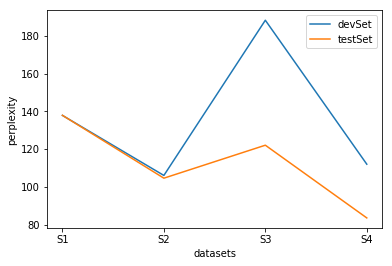

In [60]:
 
devp = [perpopt,perpopt2,perpopt3,perpopt4]
testp = [perplexity,perplexity2,perplexity3,perplexity4]
plt.plot(data,devp,label='devSet')
plt.plot(data,testp,label='testSet')
plt.xlabel('datasets')
plt.ylabel('perplexity')
plt.legend()
plt.show()